# Showcase of all supported synthetic anomalies

AutoTSAD injects synthetic anomalies into the extracted base behavior of the target time series to generate training data.
We use the introductory example time series to showcase all different anomaly types.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from common import generate_intro_example_data

from autotsad.config import ANOMALY_TYPES
from autotsad.system.anomaly.transforms import AnomalyTransform

plt.rcParams["figure.figsize"] = (20, 10)

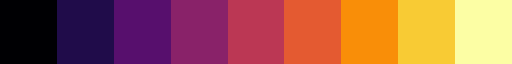

In [2]:
cm = matplotlib.colormaps["inferno"].resampled(9)
cm

array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

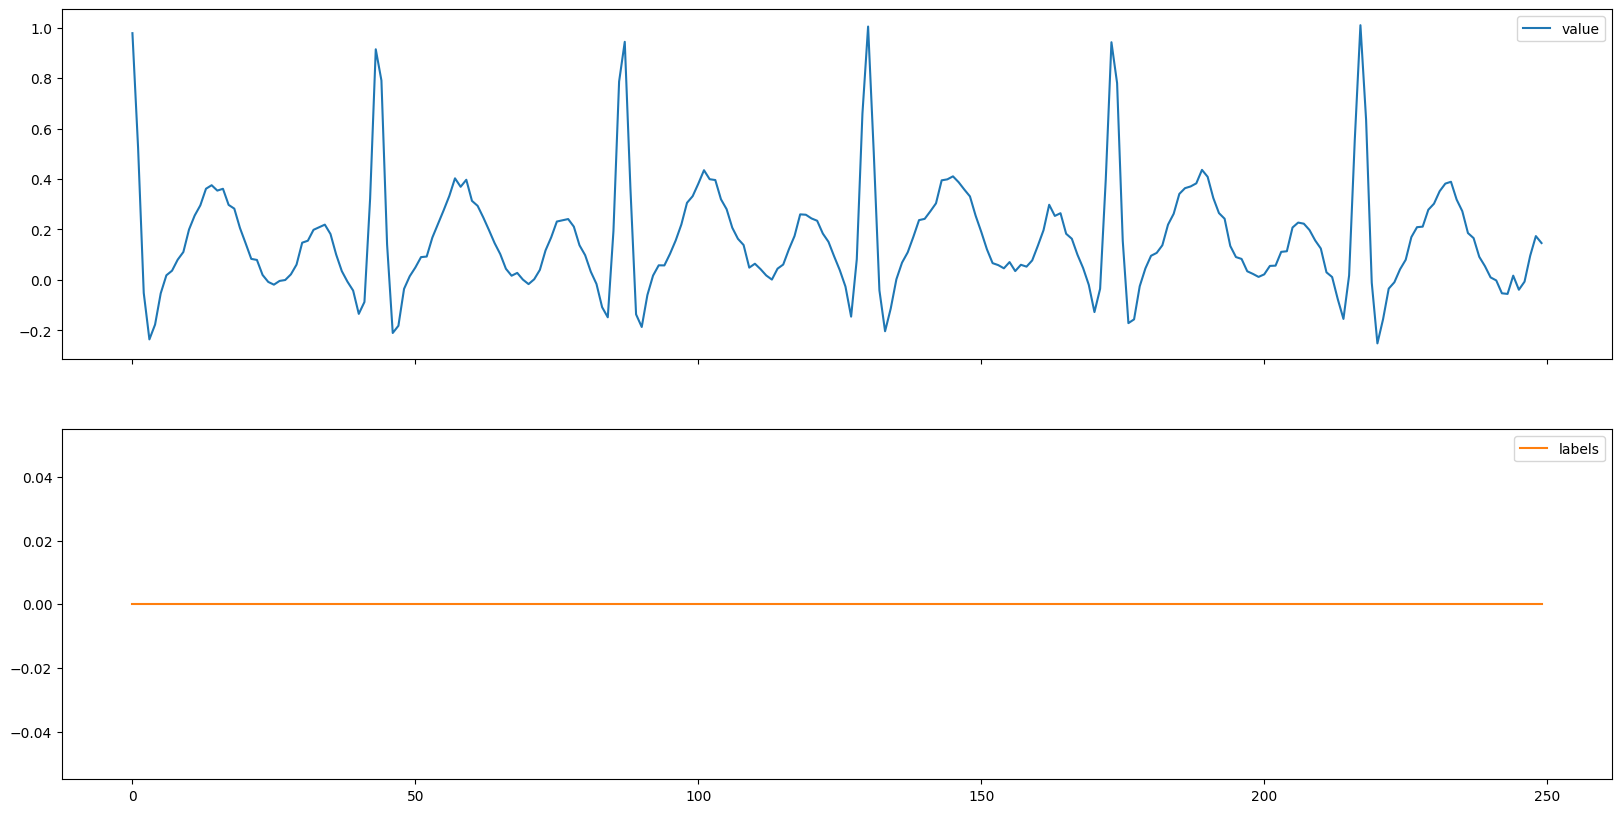

In [3]:
# Create synthetic ECG signal from introduction
df = generate_intro_example_data(anomaly_region_offset=3000).iloc[:250, :]
# add a bit of noise
df["value"] += np.random.default_rng(42).normal(0, 0.02, df.shape[0])
df[["value", "labels"]].plot(subplots=True)

(258,)
(6, 43)


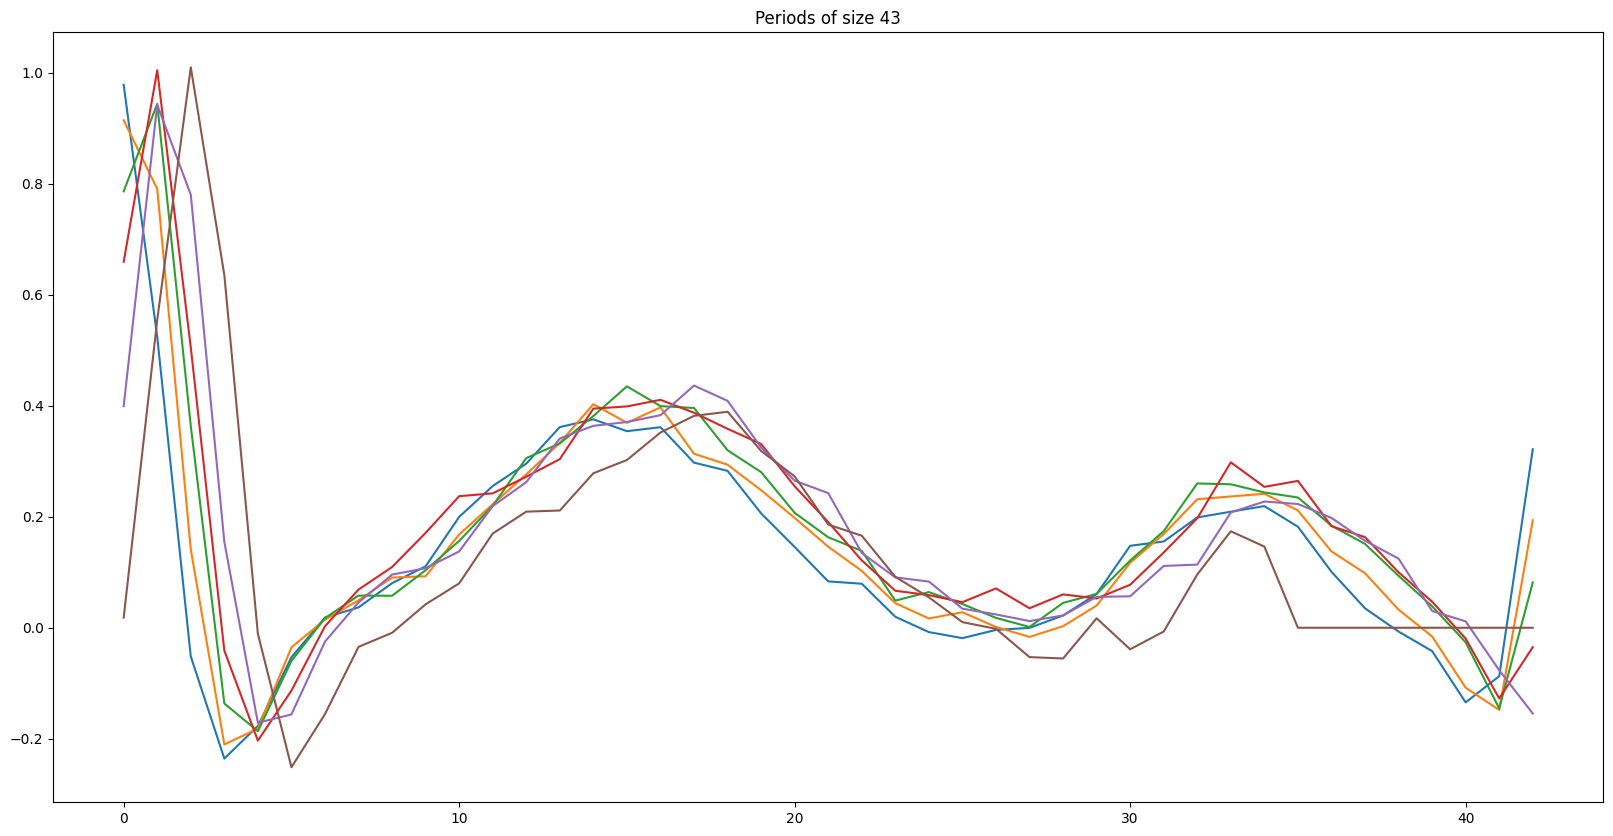

In [4]:
period_size = 43
data = df["value"].values
if data.shape[0] % period_size != 0:
    data = np.pad(data, (0, period_size - data.shape[0] % period_size))
print(data.shape)
data = data.reshape(-1, period_size)
print(data.shape)

plt.figure()
plt.title(f"Periods of size {period_size}")
for i in range(data.shape[0]):
    plt.plot(data[i, :])
plt.show()


In [5]:
# create anomalies
length = period_size
loc_s = 2*period_size
df_tmp = pd.DataFrame({
    "value": np.pad(df["value"].values, (0, 2*period_size), "constant", constant_values=(np.nan, np.nan)),
})
annotations = []

for anomaly_type in ANOMALY_TYPES:
    data = df["value"].values.copy()
    seq, labels_ = AnomalyTransform.get_factory(anomaly_type)(rng=np.random.default_rng(1), strength=1)(data[loc_s:loc_s+length])

    result = np.full(df_tmp.shape[0], fill_value=np.nan)
    offset = 0
    for snippet in [data[:loc_s], seq, data[loc_s + length:]]:
        snippet_length = snippet.shape[0]
        # print(f"{anomaly_type}: target={offset}:{offset+snippet_length} ({snippet.shape})")
        result[offset:offset+snippet_length] = snippet
        offset += snippet_length
    df_tmp[anomaly_type] = result
    if np.sum(labels_) == labels_.shape[0]:
        annotations.append((anomaly_type, loc_s, seq.shape[0]))
    else:
        pos = loc_s + np.nonzero(labels_)[0][0]
        annotations.append((anomaly_type, pos - 2, 5))

df_tmp

,value,outlier,compress,stretch,noise,smoothing,hmirror,vmirror,scale,pattern
0,0.978078,0.978078,0.978078,0.978078,0.978078,0.978078,0.978078,0.978078,0.978078,0.978078
1,0.523983,0.523983,0.523983,0.523983,0.523983,0.523983,0.523983,0.523983,0.523983,0.523983
2,-0.051677,-0.051677,-0.051677,-0.051677,-0.051677,-0.051677,-0.051677,-0.051677,-0.051677,-0.051677
3,-0.235587,-0.235587,-0.235587,-0.235587,-0.235587,-0.235587,-0.235587,-0.235587,-0.235587,-0.235587
4,-0.176953,-0.176953,-0.176953,-0.176953,-0.176953,-0.176953,-0.176953,-0.176953,-0.176953,-0.176953
...,...,...,...,...,...,...,...,...,...,...
331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_tmp.shape

(336, 10)

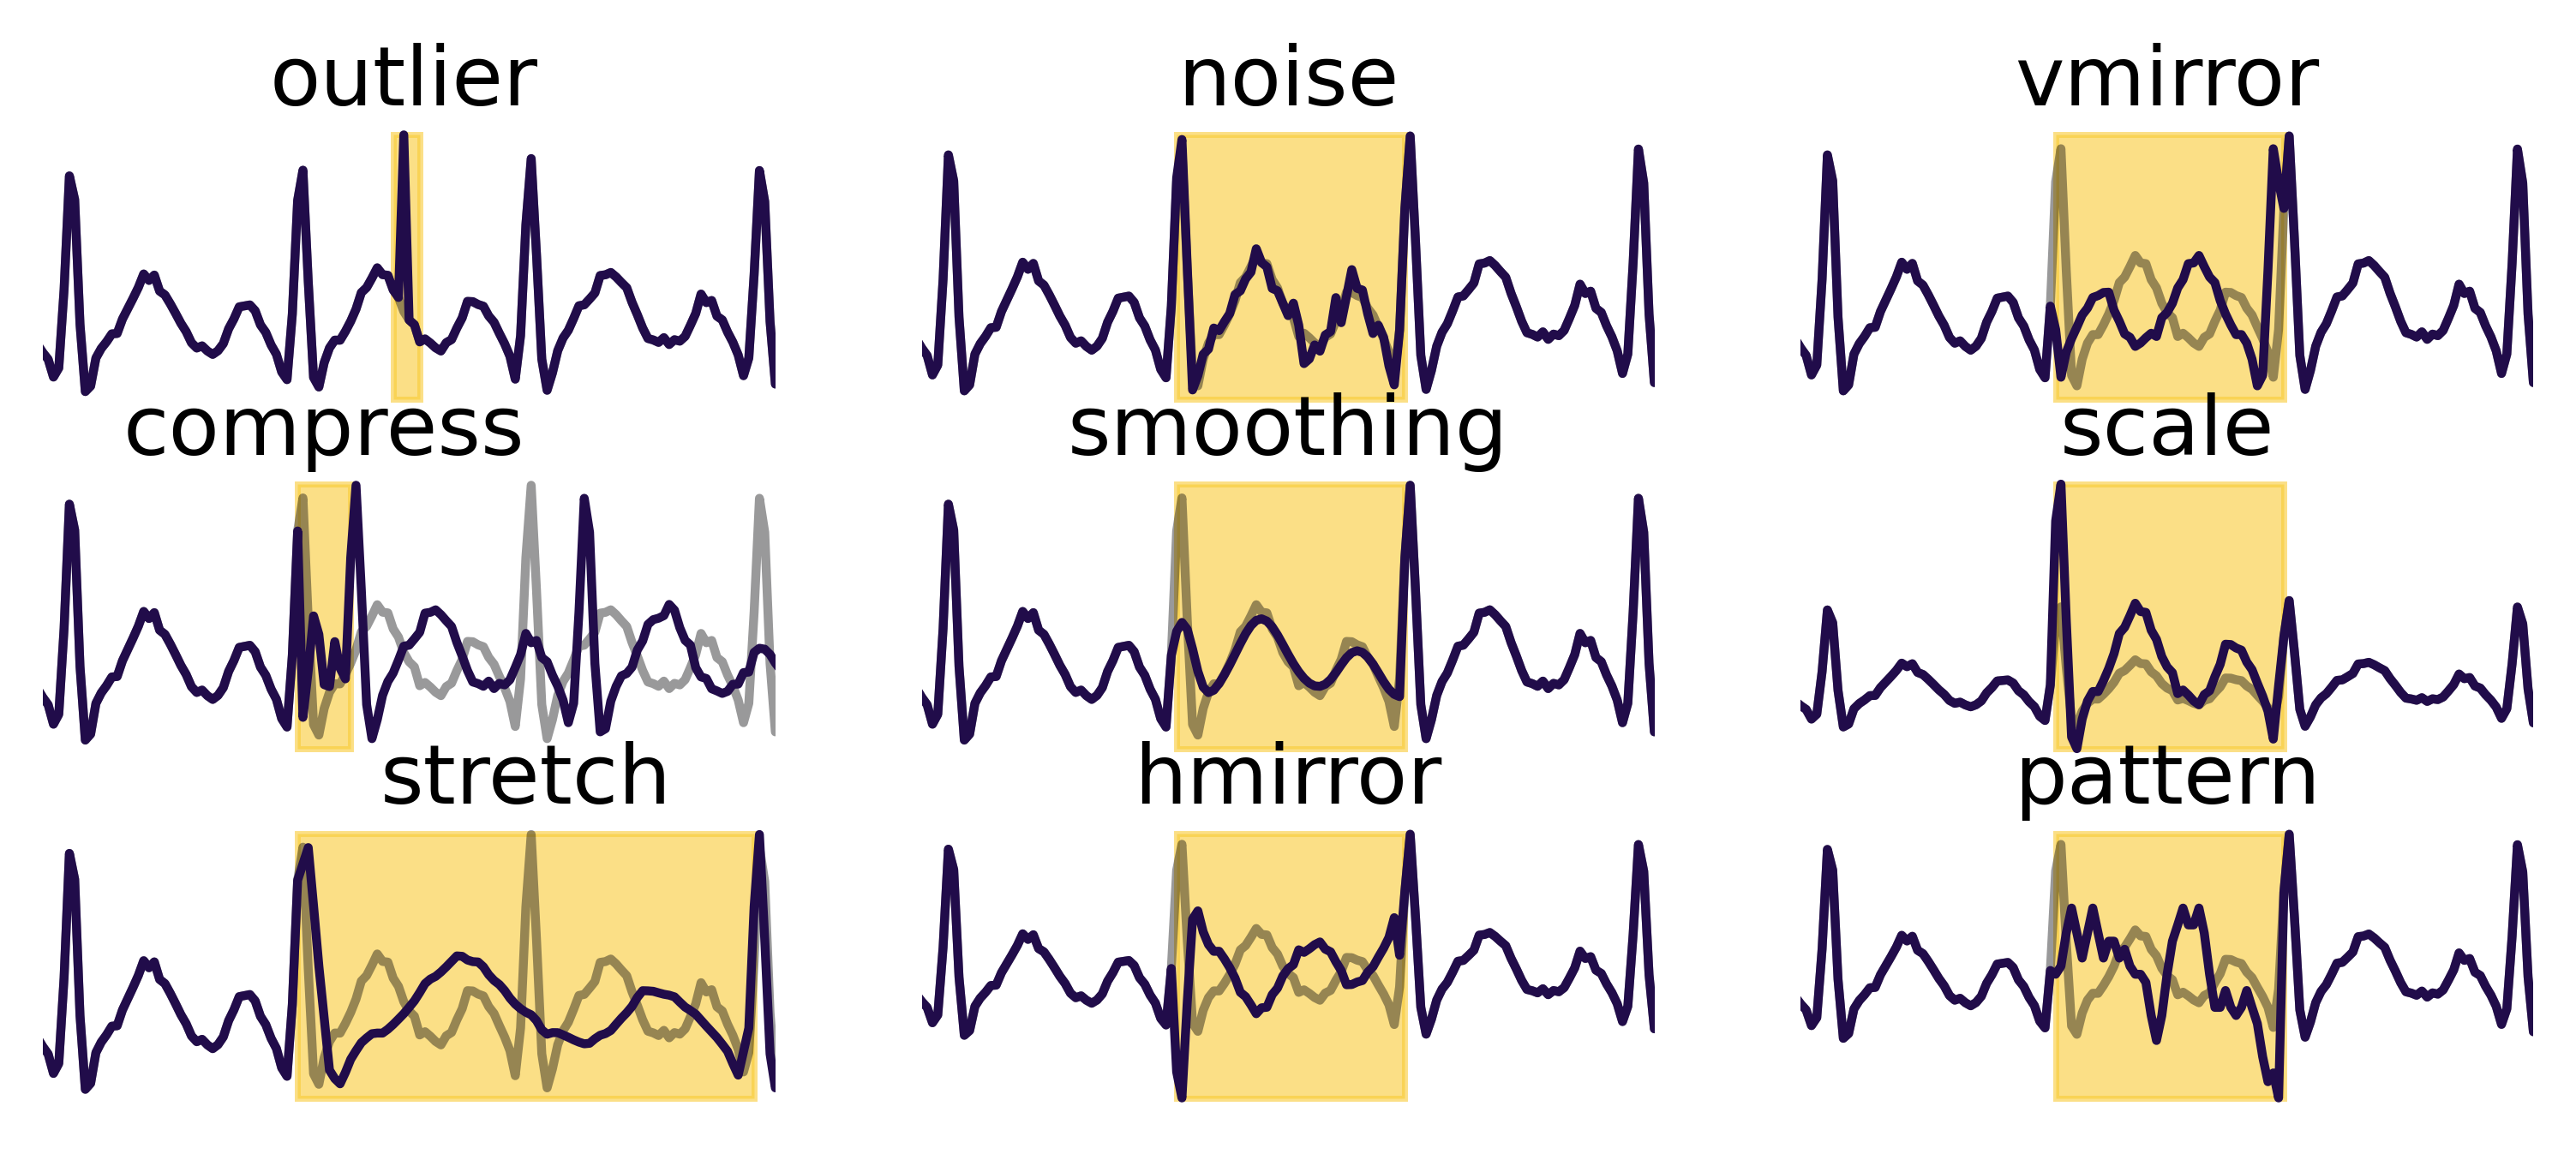

In [7]:
plt.rcParams["font.size"] = 14

anomaly_highlight_color_alpha = 0.6

# anomaly_highlight_color = "red"
# ts_color = "grey"
# new_ts_color = (0.1, 0.1, .5)

# colors = sns.cubehelix_palette(start=.25, rot=-.25, light=0.8, dark=0.2, n_colors=6)
# ts_color = colors[1]
# new_ts_color = colors[4]
# anomaly_highlight_color = sns.cubehelix_palette()[1]

ts_color = cm.colors[0]
new_ts_color = cm.colors[1]
anomaly_highlight_color = cm.colors[-2]



fig, axs = plt.subplots(len(annotations)//3, 3, sharex="all", figsize=(7.5, 3), dpi=500, squeeze=False)

for i, annotation in enumerate(annotations):
    anomaly_type, anom_idx, anom_length = annotation
    data = df_tmp[anomaly_type].values

    axis = axs[i%3, i//3]
    
    # add annotation
    y_min = np.nanmin(data)
    y_max = np.nanmax(data)
    axis.add_patch(
        Rectangle((anom_idx, y_min), anom_length, y_max-y_min, color=anomaly_highlight_color, alpha=anomaly_highlight_color_alpha)
    )

    # axis.set_title(anomaly_type)
    axis.plot(df_tmp["value"].values, label="original", color=ts_color, alpha=0.4)
    axis.plot(data, label=anomaly_type, color=new_ts_color)


    # custom annotations
    pos = (anom_idx + anom_length//2, y_max)
    axis.annotate(anomaly_type, pos, ha="center", xytext=(0, 5), textcoords="offset points")

    # display styling
    axis.axis("off")
    axis.set_xlim(period_size-5, 305-3*period_size)

fig.savefig("synthetic_anomalies.pdf", bbox_inches="tight")
fig.savefig("synthetic_anomalies.png", bbox_inches="tight")
plt.show()
